<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/convolutional_networks/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import MNIST data to train discriminator model

GAN implementation based on [this tutorial](https://github.com/jorditorresBCN/Deep-Learning-Introduccion-practica-con-Keras/blob/d85270064efe2e91278d39fa27829226fad8eccc/8.3.programando-una-GAN.ipynb)

In [1]:
import tensorflow as tf
%tensorflow_version 2.x
from tensorflow import keras
print(tf.__version__)

import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import time
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D


(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.astype("float32")).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0
11490434/11490434 [==============================] - 2s 0us/step


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Define generator and discriminator models

In [2]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(784,))) # La entrada es un verctor [1,100] pixels en escala de gris

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             9834496   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 64)        2

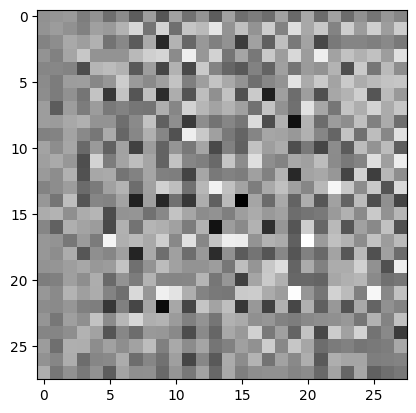

In [3]:
# create random generator
generator = make_generator_model()
generator.summary ()

# generate random image
noise_dim = 784
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# create random discriminator
discriminator = make_discriminator_model()
discriminator.summary ()

# discriminate wether image is real with a random desicion
decision = discriminator(generated_image)
print(decision)

In [4]:
# loss functions design

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # en real_loss se mide el error entre los unos (reales) y el resultado de la clasificación de una imagen real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # en fake_loss se mide el error entre los ceros (datos fake) y el resultado de la clasificación de una imagen generada
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # en total_loss sumamos los dos errores y devolvemos el resultado.
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
  # se mide el error entre los unos (reales) y el resultado de la clasificación de una imagen generada
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train models

In [5]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Generamos un vector aleatorio [256 (batch_size), 100]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # Obtenemos resultado de discriminacion con un batch de imágenes true
      fake_output = discriminator(generated_images, training=True) # Obtenemos resultado de discr. con las generadas o fake

      gen_loss = generator_loss(fake_output) # Obtenemos la loss del generador
      disc_loss = discriminator_loss(real_output, fake_output) # Obtenemos la loss del discriminador

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # almacenamos la loss del generador
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # almacenamos loss del discr.

    # aplicamos las loss a través del optimizador en cada caso
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [6]:
grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y, noise_dim]) # Generamos una semilla para visualizar nuestro generador aleatorio

# save errors
gen_loss_l, disc_loss_l = ([],[])

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time() # medimos el tiempo que consumimos en cada epoch

    gen_loss_batch, disc_loss_batch = ([],[])
    for image_batch in dataset: #para cada lote del dataset de entrenamiento - se procesa el dataset entero en cada epoch-
      gen_loss, disc_loss = train_step(image_batch)    # ejecutamos el entrenamiento -epoch-
      gen_loss_batch.append(gen_loss); disc_loss_batch.append(disc_loss)

    gen_loss_l.append(np.mean(gen_loss_batch)); disc_loss_l.append(np.mean(disc_loss_batch))

    if epoch%10==0: # generate image
      print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))
      generate_images(generator,seed,epoch)  # y generamos unas imágenes para mostrar la evolución de la red generadora en cada época
  return gen_loss_l, disc_loss_l

In [8]:
def generate_images(model, test_input, epoch=''):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
      plt.subplot(grid_size_x, grid_size_y, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray') #127.5 + 127.5
      plt.axis('off')
  plt.savefig("gan_training_epoch_%s.png"%str(epoch))
  plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 0 is 19.792845487594604 sec


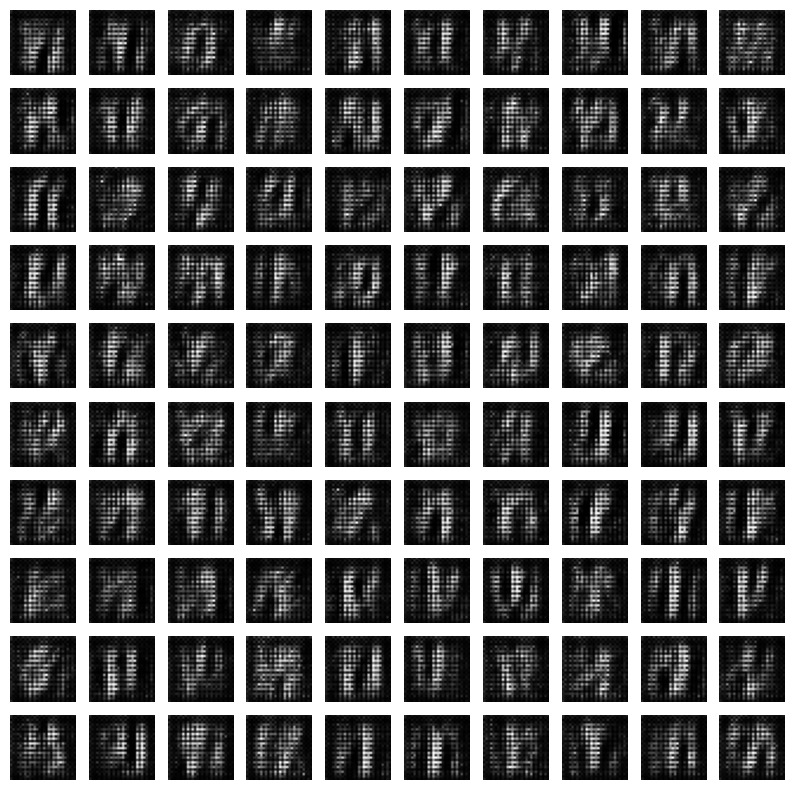

Time for epoch 10 is 12.123832941055298 sec


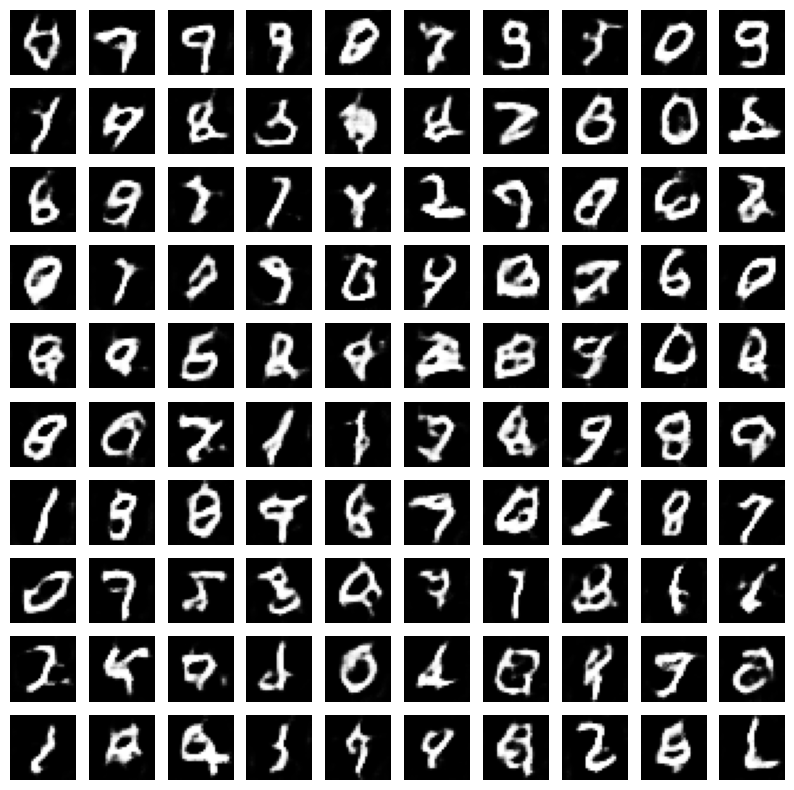

Time for epoch 20 is 12.06991982460022 sec


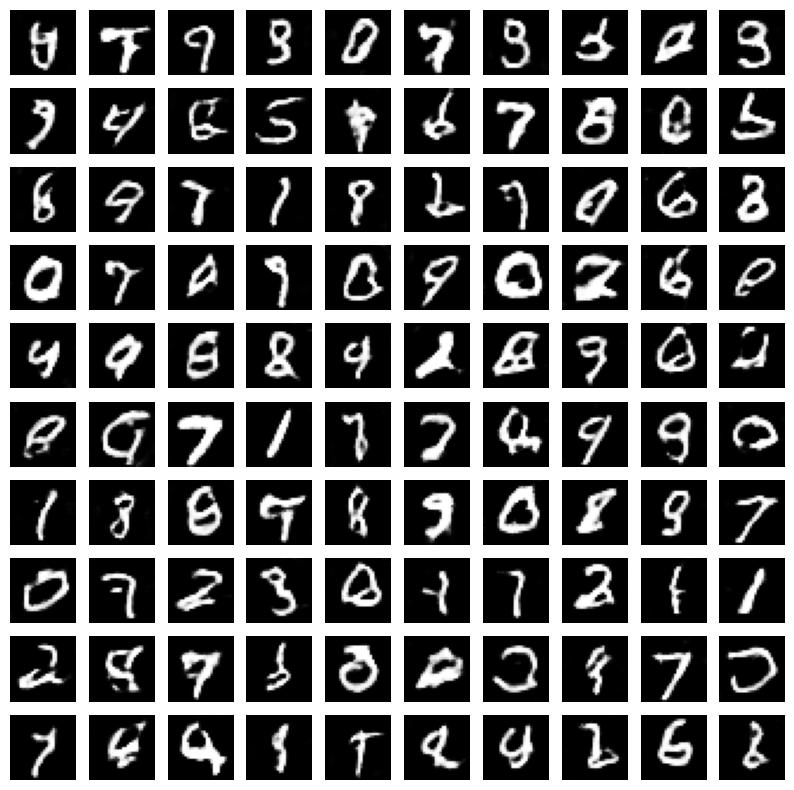

Time for epoch 30 is 12.06081223487854 sec


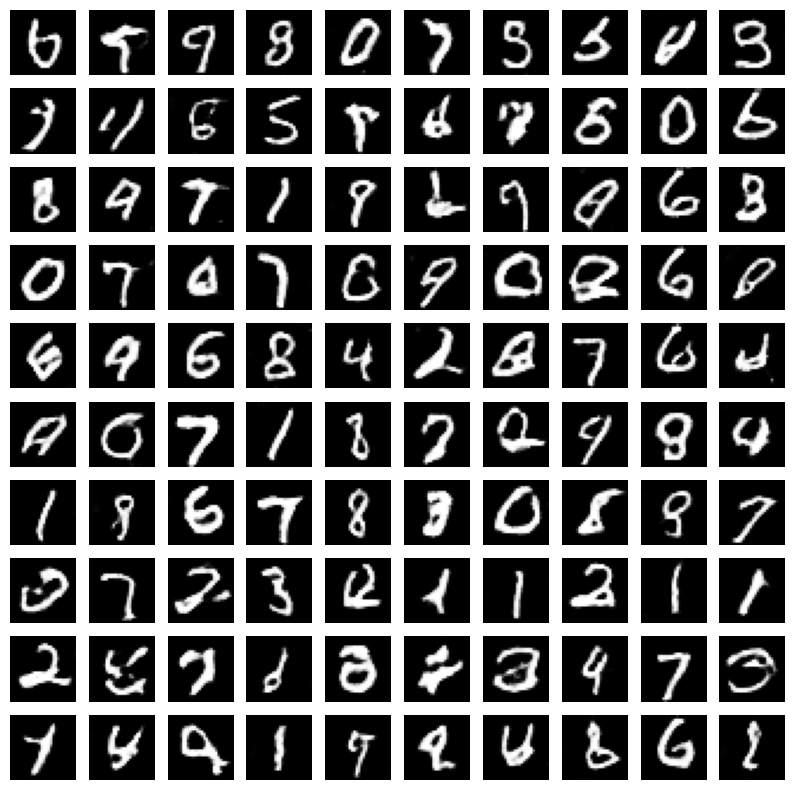

Time for epoch 40 is 12.14893651008606 sec


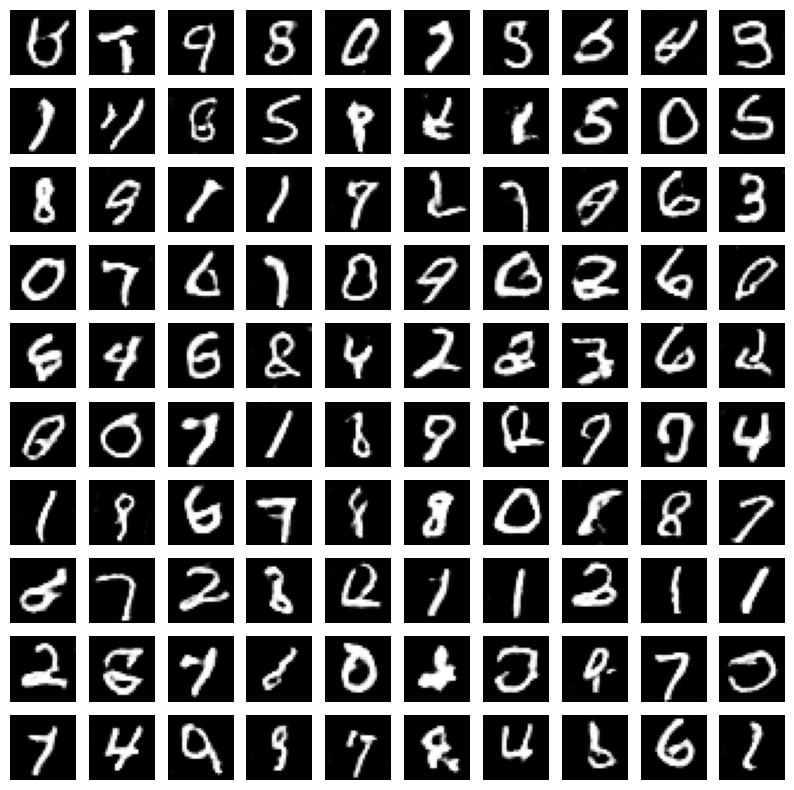

Time for epoch 50 is 12.073288440704346 sec


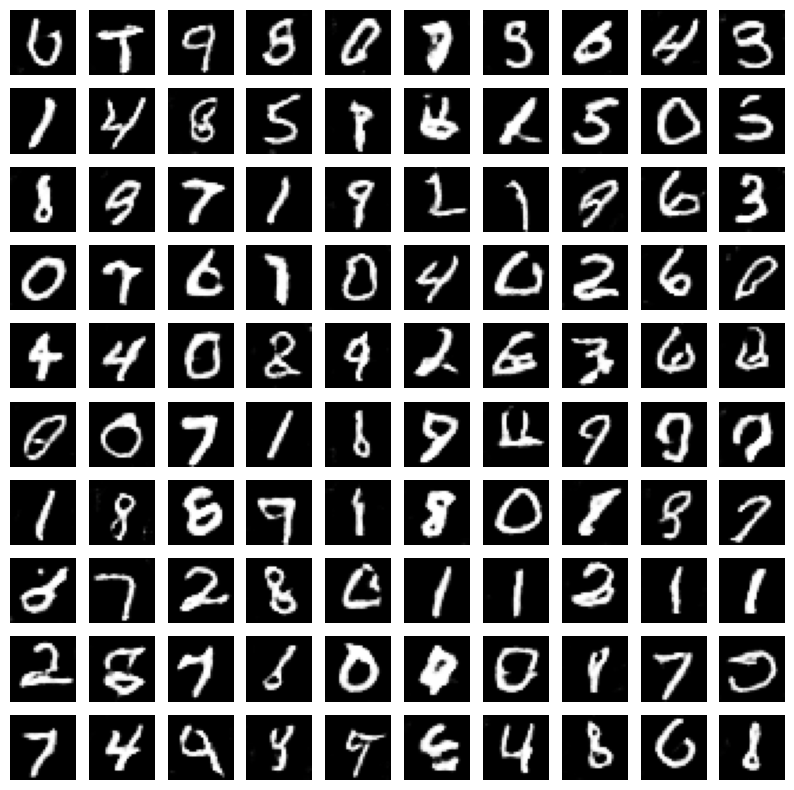

Time for epoch 60 is 12.191549062728882 sec


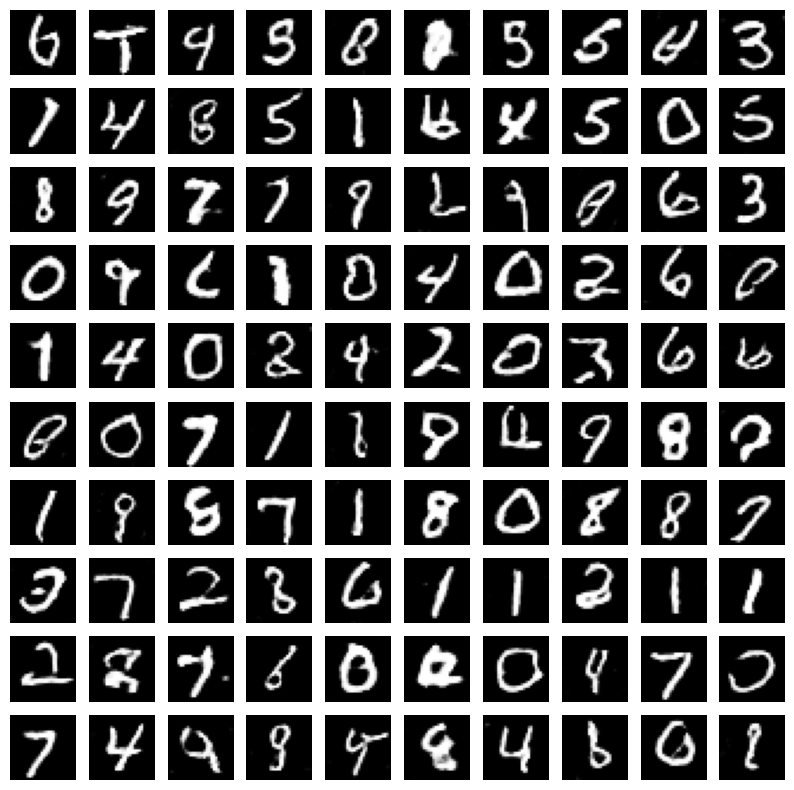

Time for epoch 70 is 12.042023658752441 sec


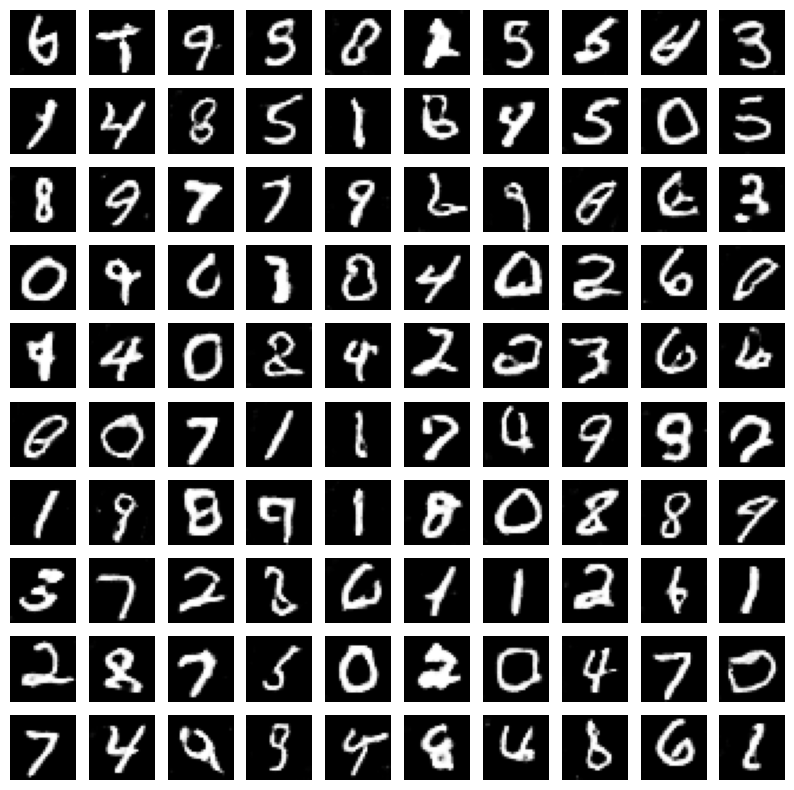

Time for epoch 80 is 12.05430793762207 sec


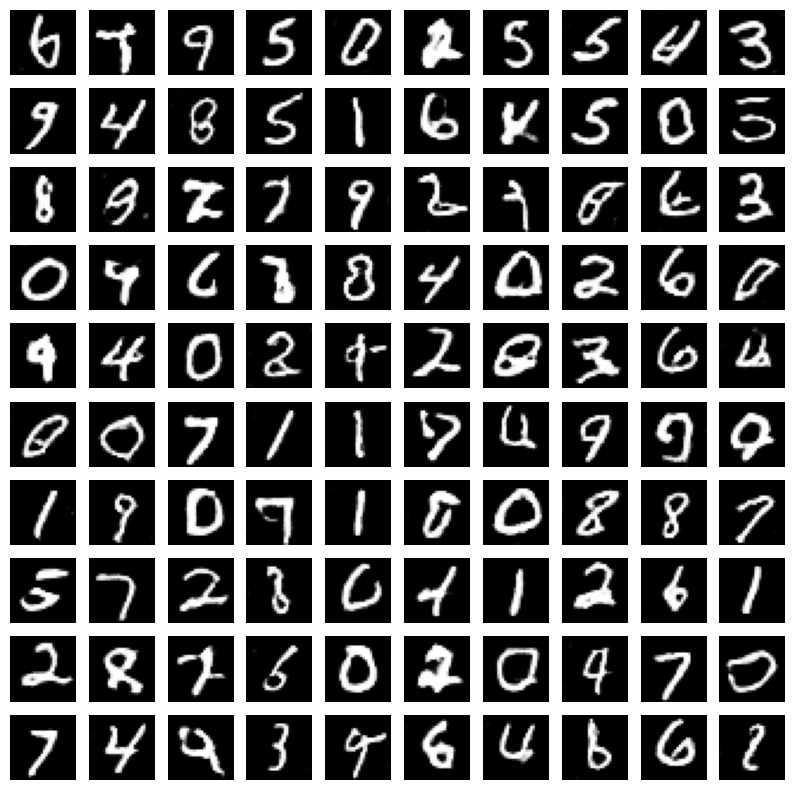

Time for epoch 90 is 12.146322250366211 sec


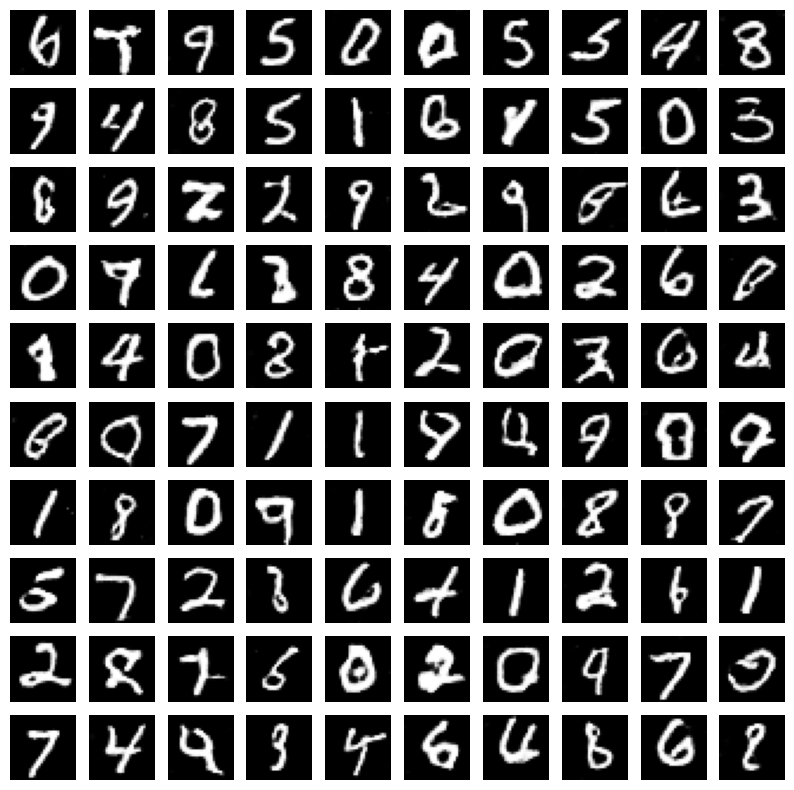

In [11]:
EPOCHS = 100
gen_loss_l, disc_loss_l = train(train_dataset, EPOCHS)

# save training data
disc=pd.DataFrame(disc_loss_l); disc.to_csv("disc.csv")
gen=pd.DataFrame(gen_loss_l); gen.to_csv("gen.csv")

## automatically download training data
#from google.colab import files
#files.download('disc.csv'); files.download('gen.csv')

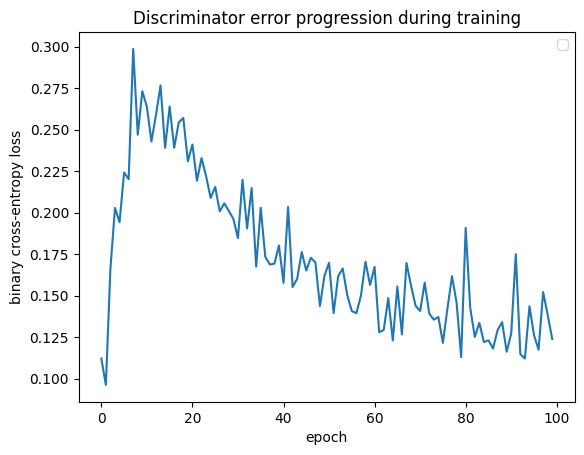

In [12]:
plt.plot(disc_loss_l)
plt.legend('discriminator loss')
plt.xlabel('epoch'); plt.ylabel('binary cross-entropy loss'); plt.legend([])
plt.title('Discriminator error progression during training')
plt.savefig('disc_loss.png')

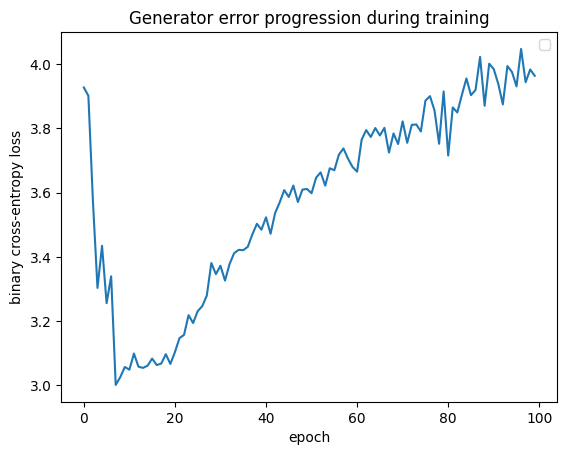

In [13]:
plt.plot(gen_loss_l)
plt.legend('generator loss')
plt.xlabel('epoch'); plt.ylabel('binary cross-entropy loss'); plt.legend([])
plt.title('Generator error progression during training')
plt.savefig('gen_loss.png')

# load class hand-written digits

In [14]:
!git clone https://github.com/asgutierrt/Introduction-to-IA.git

Cloning into 'Introduction-to-IA'...
remote: Enumerating objects: 1103, done.
remote: Counting objects: 100% (986/986), done.
remote: Compressing objects: 100% (963/963), done.
remote: Total 1103 (delta 98), reused 851 (delta 21), pack-reused 117
Receiving objects: 100% (1103/1103), 47.31 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [15]:
import pandas as pd

# assign directory
data_path='/content/Introduction-to-IA/convolutional_networks/mnist_data/'

# format images
def x_format(x):
  return (1 - float(x) - 0.5) *2  # features' space of [-1,1] as suggested on the implementation

# read our class' images
own_images=pd.read_csv(data_path+'hand_written_numbers.csv',index_col=0)
mask = own_images['label'] != 'X'
own_images.drop("label",axis=1,inplace=True)

img_digits=own_images[mask].applymap(x_format)
img_x=own_images[~mask].applymap(x_format)

# as tensor
img_digits = img_digits.to_numpy().reshape(img_digits.shape[0], 28, 28).astype('float32')
ts_img_digits = tf.convert_to_tensor(img_digits)
img_x = img_x.to_numpy().reshape(img_x.shape[0], 28, 28).astype('float32')
ts_img_x = tf.convert_to_tensor(img_x)

# discriminate images from MNIST database
val_image_scr=discriminator(ts_img_digits).numpy()
x_image_scr=discriminator(ts_img_x).numpy()

<ipython-input-22-f21144a23717>:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if title_text!='':


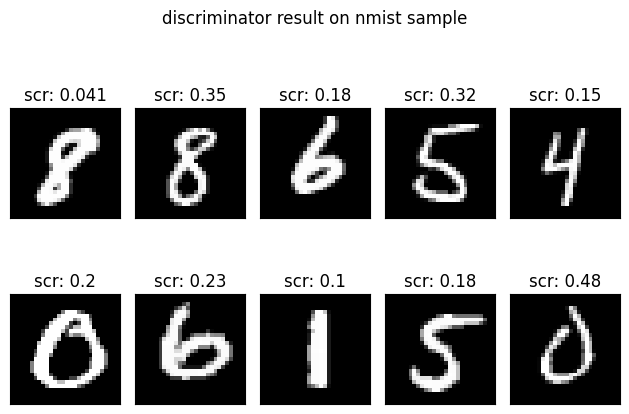

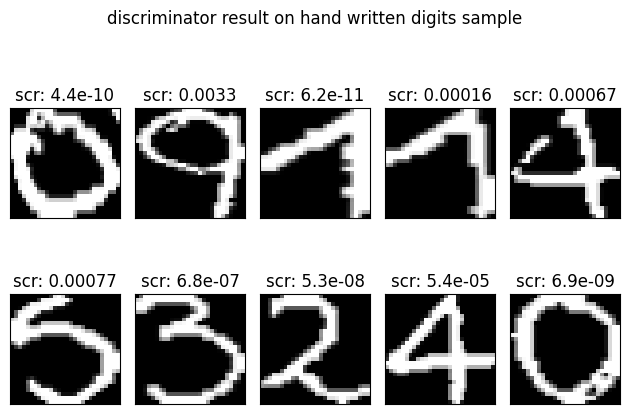

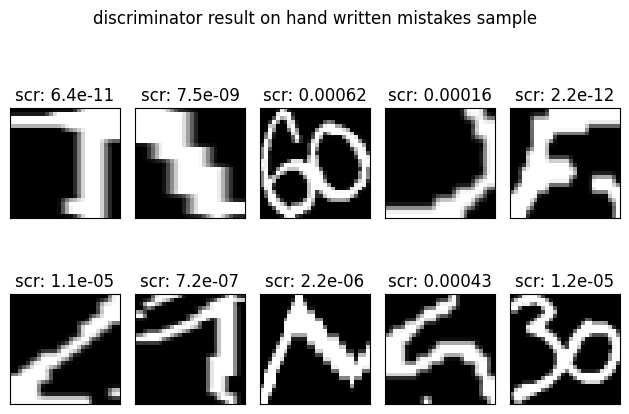

In [22]:
# Helper function to show a list of images with their relating titles
def show_images(images, title_texts, figsize=(8,8), title=''):
    cols = 5
    rows = int(np.ceil(len(images)/cols))
    fig=plt.figure()
    index = 1
    for image,title_text  in zip(images, title_texts):
        ax=plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text!='':
            label='scr: {0:3.2}'.format(title_text[0])
            ax.set_title(label);
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        index += 1
    fig.suptitle(title)
    plt.tight_layout()

def sample_disc(sample,name,mask=[]):
  # Show some random training and test images
  if mask==[]:
    images_2_show = [sample[random.randint(1, sample.shape[0])] for _ in range(10)]
  else:
    images_2_show = [sample[x] for x in mask]
  titles_2_show = discriminator(tf.convert_to_tensor(images_2_show)).numpy()
  show_images(images_2_show, titles_2_show, title='discriminator result on '+name)
  plt.savefig('disc_%s.png'%name);

import random
sample=train_images; name='nmist sample'
sample_disc(sample,name)

sample=ts_img_digits; name='hand written digits sample'
sample_disc(sample,name)

sample=ts_img_x; name='hand written mistakes sample'
sample_disc(sample,name)

## our best/worst digits according to the discriminator trained on MNIST

<ipython-input-22-f21144a23717>:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if mask==[]:
<ipython-input-22-f21144a23717>:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if title_text!='':


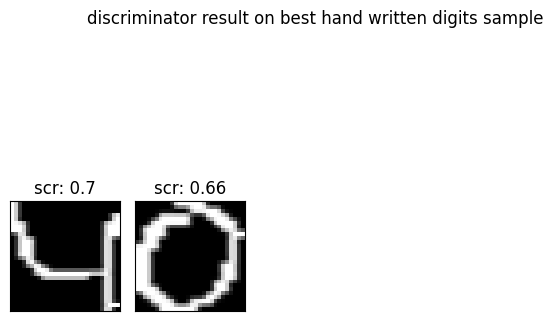

In [23]:
mask=np.where(val_image_scr>0.5)[0]
sample=img_digits; name='best hand written digits sample'
sample_disc(sample,name,mask=mask)

In [24]:
print('percentage of fake data in our written dataset: ', sum(val_image_scr<0.5)/sum(val_image_scr>0)*100, '%')

percentage of fake data in our written dataset:  [99.71988796] %


In [25]:
print('percentage of fake data in our non-human-distinguisable images): ', sum(x_image_scr<0.5)/sum(x_image_scr>0)*100, '%')

percentage of fake data in our non-human-distinguisable images):  [100.] %
